In [27]:
import nibabel as nib
import numpy as np
import scipy as sp

In [2]:
epi_img = nib.load('OU_data/niftiDATA_Subject001_Condition000.nii')
epi_img_data = epi_img.get_fdata()
epi_img_data.shape

(91, 109, 91, 748)

In [4]:
import matplotlib.pyplot as plt
def show_slices(slices):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    for i, slice in enumerate(slices):
        axes[i].imshow(slice.T, cmap="gray", origin="lower")

Text(0.5, 0.98, 'Center slices for EPI image')

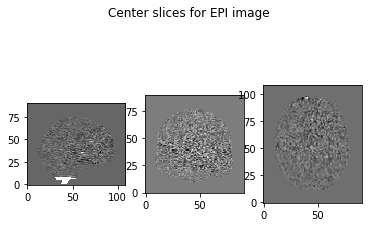

In [6]:
slice_0 = epi_img_data[45, :, :,10]
slice_1 = epi_img_data[:, 54, :,10]
slice_2 = epi_img_data[:, :, 45,10]
show_slices([slice_0, slice_1, slice_2])
plt.suptitle("Center slices for EPI image")  # doctest: +SKIP

In [9]:
# import masks
masks_img = nib.load('OU_data/Masks/networks.nii')

In [13]:
from nilearn.input_data import NiftiMapsMasker
masker = NiftiMapsMasker(maps_img=masks_img, standardize=True,
                         memory='nilearn_cache', verbose=5)

time_series = masker.fit_transform(epi_img)

[NiftiMapsMasker.fit_transform] loading regions from Nifti1Image('OU_data/Masks/networks.nii')


/Users/hstrey/anaconda3/envs/fMRI/lib/python3.6/site-packages/nilearn/_utils/cache_mixin.py:296: UserWarning: memory_level is currently set to 0 but a Memory object has been provided. Setting memory_level to 1.
  warnings.warn("memory_level is currently set to 0 but "


________________________________________________________________________________
[Memory] Calling nilearn.input_data.base_masker.filter_and_extract...
filter_and_extract(<nibabel.nifti1.Nifti1Image object at 0x7ff298fd3470>, <nilearn.input_data.nifti_maps_masker._ExtractionFunctor object at 0x7ff268ba9940>, 
{ 'allow_overlap': True,
  'detrend': False,
  'dtype': None,
  'high_pass': None,
  'low_pass': None,
  'maps_img': <nibabel.nifti1.Nifti1Image object at 0x7ff2692b9c50>,
  'mask_img': None,
  'smoothing_fwhm': None,
  'standardize': True,
  't_r': None,
  'target_affine': None,
  'target_shape': None}, confounds=None, dtype=None, memory=Memory(location=nilearn_cache/joblib), memory_level=1, verbose=5)
[NiftiMapsMasker.transform_single_imgs] Loading data from Nifti1Image('OU_data/niftiDATA_Subject001_Condition000.nii')
[NiftiMapsMasker.transform_single_imgs] Extracting region signals
[NiftiMapsMasker.transform_single_imgs] Cleaning extracted signals
_______________________________

/Users/hstrey/anaconda3/envs/fMRI/lib/python3.6/site-packages/nilearn/input_data/nifti_maps_masker.py:332: UserWarning: Persisting input arguments took 10.99s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  verbose=self.verbose)


In [15]:
time_series.shape

(748, 32)

In [19]:
mpfc = time_series[:,0]
llp = time_series[:,1]
rlp = time_series[:,2]
pcc = time_series[:,3]

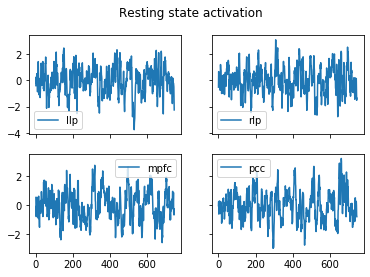

In [20]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
f.suptitle('Resting state activation')
ax1.plot(llp, label="llp")
ax1.legend()
ax2.plot(rlp,label = "rlp")
ax2.legend()
ax3.plot(mpfc,label = "mpfc")
ax3.legend()
ax4.plot(pcc,label = "pcc")
ax4.legend()

In [18]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

def OUcross(data1,data2):
    x1 = data1 + data2
    x2 = data1 - data2
    x1_A,x1_dA, x1_tau ,x1_dtau= OUresult(x1,0.802)
    x2_A, x2_dA, x2_tau ,x2_dtau= OUresult(x2,0.802)
    return (x1_A - x2_A)/x2_A, np.sqrt(x1_dA**2 + x1_A**2*x2_dA**2/x2_A**4)

mean:  -2.5499314e-09
var:  0.999999880790714
N:  748
relaxation time: 4.276602482254818 SD tau 0.5592808445022631
A  0.9952146587322573 SD A 0.11884219318742377


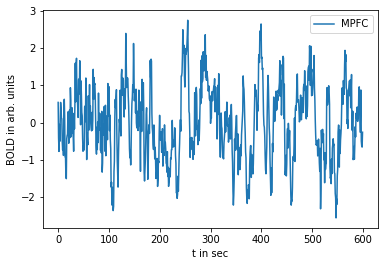

In [23]:
print("mean: ",mpfc.mean())
print("var: ",mpfc.std()**2)
N=len(mpfc)
print("N: ",N)
mpfc_A,mpfc_sA, mpfc_tau, mpfc_dtau = OUresult(mpfc,0.802)
print("relaxation time:",mpfc_tau, "SD tau", mpfc_dtau)
print("A ",mpfc_A,"SD A",mpfc_sA)
mpfc_norm=mpfc/np.sqrt(mpfc_A)
t = np.arange(N)*0.802 # tR = 0.802 sec
plt.plot(t,mpfc,label="MPFC")
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")
plt.legend()

mean:  1.2749657e-09
var:  1.0
N:  748
relaxation time: 6.181133648572227 SD tau 0.9407212374820123
A  0.9937792702457918 SD A 0.14192204478042578
1.0031251


Text(0, 0.5, 'BOLD in arb. units')

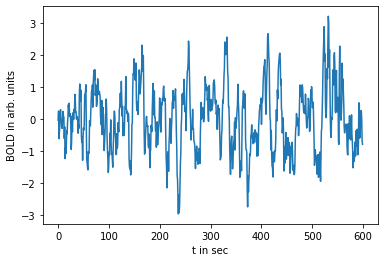

In [24]:
print("mean: ",pcc.mean())
print("var: ",pcc.std()**2)
N=len(pcc)
print("N: ",N)
pcc_A,pcc_sA, pcc_tau, pcc_dtau = OUresult(pcc,0.802)
print("relaxation time:",pcc_tau, "SD tau", pcc_dtau)
print("A ",pcc_A,"SD A",pcc_sA)
pcc_norm=pcc/np.sqrt(pcc_A)
print(pcc_norm.std())
plt.plot(t,pcc)
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")

mean:  -1.5299587e-08
var:  0.9999996423721633
N:  748
relaxation time: 3.9463579348115476 SD tau 0.5018782627386921
A  1.0002102885856168 SD A 0.11521987937030302
0.9998947


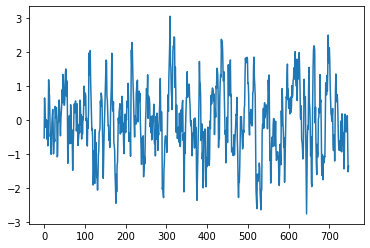

In [25]:
plt.plot(rlp)
print("mean: ",rlp.mean())
print("var: ",rlp.std()**2)
N=len(rlp)
print("N: ",N)
rlp_A,rlp_sA, rlp_tau, rlp_dtau = OUresult(rlp,0.802)
print("relaxation time:",rlp_tau, "SD tau", rlp_dtau)
print("A ",rlp_A,"SD A",rlp_sA)
rlp_norm=rlp/np.sqrt(rlp_A)
print(rlp_norm.std())

mean:  7.649794e-09
var:  1.0
N:  748
relaxation time: 4.5815683180901114 SD tau 0.6224672731342222
A  1.0101038497486168 SD A 0.12581292842541592
0.99498606


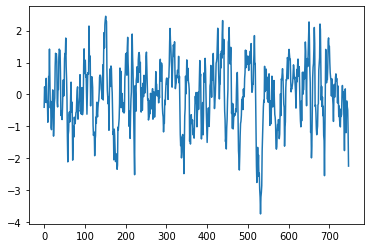

In [26]:
plt.plot(llp)
print("mean: ",llp.mean())
print("var: ",llp.std()**2)
N=len(llp)
print("N: ",N)
llp_A,llp_sA, llp_tau, llp_dtau = OUresult(llp,0.802)
print("relaxation time:",llp_tau, "SD tau", llp_dtau)
print("A ",llp_A,"SD A",llp_sA)
llp_norm=llp/np.sqrt(llp_A)
print(llp_norm.std())

In [28]:
print("MPFC:PCC",OUcross(mpfc_norm,pcc_norm))
print("MPFC:RLP",OUcross(mpfc_norm,rlp_norm))
print("MPFC:LLP",OUcross(mpfc_norm,llp_norm))
print("PCC:RLP",OUcross(pcc_norm,rlp_norm))
print("PCC:LLP",OUcross(pcc_norm,llp_norm))
print("RLP:LLP",OUcross(rlp_norm,llp_norm))
print("Pearson MPFC:PCC",sp.stats.pearsonr(mpfc_norm,pcc_norm))
print("Pearson MPFC:RLP",sp.stats.pearsonr(mpfc_norm,rlp_norm))
print("Pearson MPFC:LLP",sp.stats.pearsonr(mpfc_norm,llp_norm))
print("Pearson PCC:RLP",sp.stats.pearsonr(pcc_norm,rlp_norm))
print("Pearson PCC:LLP",sp.stats.pearsonr(pcc_norm,llp_norm))
print("Pearson RLP:LLP",sp.stats.pearsonr(rlp_norm,llp_norm))

MPFC:PCC (1.24352709667593, 0.4607288547925293)
MPFC:RLP (2.049371946486653, 0.4863327520901467)
MPFC:LLP (0.5482297674313436, 0.35299979415101546)
PCC:RLP (1.81397407238437, 0.5183808019104124)
PCC:LLP (1.706202134344883, 0.5368771986827021)
RLP:LLP (4.769431356898703, 0.689550238102325)
Pearson MPFC:PCC (0.3835733986204911, 1.2527006079268397e-27)
Pearson MPFC:RLP (0.5076796974903413, 2.991420395554449e-50)
Pearson MPFC:LLP (0.215704136885295, 2.5246740315438665e-09)
Pearson PCC:RLP (0.4741518936360357, 3.4251448338766864e-43)
Pearson PCC:LLP (0.4588268799313747, 3.2317354653934523e-40)
Pearson RLP:LLP (0.7026235768656977, 2.3372206676814476e-112)
